In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline


Here we start with simple cross-validation, no balancing (later will add balancing)

In [156]:
datadir = "../data"
savedir = "../saves/catboost_multiple"
if not os.path.exists(savedir):
    os.makedirs(savedir)
print(os.listdir(datadir))
df_train_single = pd.read_csv(os.path.join(datadir, "single_muts_train.csv"))
df_train_multiple = pd.read_csv(os.path.join(datadir, "multiple_muts_train.csv"))
df_train = pd.concat([df_train_single, df_train_multiple], ignore_index=True)

df_test_single = pd.read_csv(os.path.join(datadir, "single_muts_test.csv"))
df_test_multi = pd.read_csv(os.path.join(datadir, "multiple_muts_test.csv"))

df_train['topology'] = df_train.name.apply(lambda x: x.split("_")[0])
# df_test['topology'] = df_test.name.apply(lambda x: x.split("_")[0])

df_train['wt_name'] = df_train.name.apply(lambda x: x.split(".")[0])
df_test_single['wt_name'] = df_test_single.name.apply(lambda x: x.split(".")[0])
df_test_multi['wt_name'] = df_test_multi.name.apply(lambda x: x.split(".")[0])


df_train = df_train.loc[~df_train.stabilityscore.isnull()].reset_index(drop=True)
# df_test = df_test.loc[~df_test.stabilityscore.isnull()]

['features', 'multiple_muts_test.csv', 'multiple_muts_train.csv', 'pdb', 'pdb_names.csv', 'pdb_names_with_cmaps.csv', 'single_muts_test.csv', 'single_muts_train.csv', 'wt_sequences.csv']


In [157]:
#df_train.secondary_structure.apply(lambda x: )

In [158]:
cmap_df = pd.read_csv("../data/pdb_names_with_cmaps.csv")

In [199]:
from torch.utils.data import Dataset, Subset, DataLoader
import torch


class CMapDataset(Dataset):
    def __init__(self, df, cmaps_path="../data/pdb_names_with_cmaps.csv"):
        self.cmaps_path = cmaps_path
        self.cmap_df = pd.read_csv(cmaps_path)
        self.df = df
        self.cmap_paths = {
             name: (path, sequence)
             for name, path, sequence in self.cmap_df[['name', "cmap_path", "sequence"]].values
        }
        self.cmap_paths["HHH_rd1_0142"] = self.cmap_paths["HHH_0142"]
        self.cmap_paths["EHEE_rd1_0882"] = self.cmap_paths["EHEE_0882"]
        # print(self.cmap_df.columns)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        # print(self.df.loc[idx])
        mutated_sequence = self.df.loc[idx, "sequence"]
        name = self.df.loc[idx, "wt_name"]
        score = self.df.loc[idx, "stabilityscore"]
        path, wt_sequence = self.cmap_paths[name]
        offset = 43 - len(wt_sequence)
        pos = [
            i
            for i, (a, b) in enumerate(zip(mutated_sequence[offset], wt_sequence))
            if a != b
        ]
        data = np.load(path)['data'].copy()
        n = data.shape[0]
        offset = 43 - n
        if offset > 0:
            data = np.pad(data, ((offset, 0), (offset, 0)))
        mask = np.ones_like(data)
        for i in pos:
            mask[pos, :] = 0
            mask[:, pos] = 0
        masked_data = np.stack([data, mask], axis=0)
        return name, masked_data, score
    

ds = CMapDataset(df_train)
for i in ds:
    print(i[1].shape)
    break

import torch.nn as nn
from torchvision.models import resnet18
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict, defaultdict


class ResnetModel:
    def __init__(self):
        model = resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = nn.Linear(in_features=512, out_features=1, bias=False)
        self.model = model
        self.loss_func = nn.MSELoss()
        self.history = OrderedDict()

    def fit(self, train_ds, eval_set=None, n_epochs=10, batch_size=256, max_batches=-1):
        dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        if eval_set is None:
            test_dataloader = None
        else:
            test_dataloader = DataLoader(eval_set, batch_size=batch_size)
        self.history = OrderedDict()
        for epoch in range(n_epochs):
            self.history[epoch] = defaultdict(list)
            for i, batch in enumerate(tqdm(dataloader)):
                if max_batches > 0 and i > max_batches:
                    break
                names, x_batch, gt_scores = batch
                predictions = self.model(x_batch.float())
                loss = self.loss_func(predictions, gt_scores.float())
                self.model.zero_grad()
                loss.backward()
                self.history[epoch]['loss'].append(loss.detach().cpu().item())
                #break
            # break
            if eval_set is None:
                continue
            metrics = self.eval_metrics(eval_set)
            for k, v in metrics.items():
                self.history[epoch][k] = [v]
        pass
    def eval_metrics(self, eval_ds, batch_size=256, metrics=[]):
        data_loader = DataLoader(eval_ds, batch_size=batch_size)
        all_preds = []
        all_gt = []
        for batch in data_loader:
            names, x_batch, gt_scores = batch
            preds = self.model.forward(x_batch.float())
            all_preds.append(preds.detach().cpu().item())
            all_gt.append(gt_scores.detach().cpu().item())
        all_preds = np.concatenate(all_preds, 0)
        all_gt = np.concatenate(all_gt, 0)
        result = {}
        for n, metric_func in metrics:
            value = metric_func(all_gt, all_preds)
            result[n] = value
        return result

    def predict(self, test_ds, batch_size=256):
        data_loader = DataLoader(test_ds, batch_size=batch_size)
        all_predictions = []
        all_targets = []
        for batch in tqdm(data_loader):
            names, x_batch, gt_scores = batch
            predictions = self.model(x_batch.float())
            all_predictions.append(predictions.detach().cpu().numpy())
            all_targets.append(gt_scores.detach().cpu().numpy())
        all_predictions = np.concatenate(all_predictions)
        all_targets = np.concatenate(all_targets)
        return all_predictions, all_targets
        pass

    def save_model(self, filename):
        torch.save(filename, self.model)
        pass

    def load(self, filename):
        data = torch.load(filename)
        self.model.load_state_dict(data)

(2, 43, 43)


# 1. Contact Maps:  single mutations

In [200]:
sorted(set([x for xs in df_test.sequence for x in xs]))
#df_train[['sequence', "stabilityscore"]].values


['A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [201]:
aa = """Alanine	Ala	A
Arginine	Arg	R
Asparagine	Asn	N
Aspartic Acid	Asp	D
Cysteine	Cys	C
Glutamic Acid	Glu	E
Glutamine	Gln	Q
Glycine	Gly	G
Histidine	His	H
Isoleucine	Ile	I
Leucine	Leu	L
Lysine	Lys	K
Methionine	Met	M
Phenylalanine	Phe	F
Proline	Pro	P
Serine	Ser	S
Threonine	Thr	T
Tryptophan	Trp	W
Tyrosine	Tyr	Y
Valine	Val	V"""

aadict = dict()
for line in aa.split("\n"):
    data = line.split()
    if len(data)< 3:
        continue
    name = " ".join(data[0:-2])
    l3, l1 = data[-2:]
    aadict[l1] = (name, l3)
aa = sorted(aadict)
aa2idx = {x: i for i, x in enumerate(aa)}

ss2idx = {"E":0, "T": 1, "H": 2}

In [202]:
train_ds_full = CMapDataset(df_train)
test_ds_single = CMapDataset(df_test_single)
test_ds_multi = CMapDataset(df_test_multi)

In [203]:
NFOLDS = 5
RANDOM_SEED = 42

SAVE_PREFIX = os.path.join(savedir, "resnet_kf_")
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor


In [ ]:
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1000

split_data = dict()
for fold, (train_index, test_index) in enumerate(kf.split(x_full_train)):
    split_data[fold] = (train_index, test_index)

    train_ds = Subset(train_ds_full, train_index)
    val_ds = Subset(train_ds_full, test_index)
    # next model-specific
    #model = CatBoostRegressor(iterations=NITERATIONS, depth=3, learning_rate=1.0, loss_function='RMSE',
    #                          metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    model = ResnetModel()
    #train the model
    model.fit(train_ds, eval_set=val_ds)
    # make the prediction using the resulting model
    pred_train = model.predict(train_ds)
    pred_val = model.predict(val_ds)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    break


  0%|          | 0/118 [00:00<?, ?it/s]

In [180]:
# predictions, gt = pred_train
# r2_score(gt, predictions)

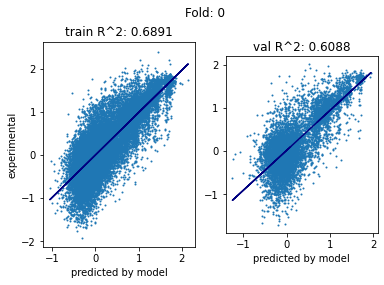

Train (using mean prediction) R^2= 0.6730653003586202
Train (using median prediction) R^2= 0.6730653003586202
Test (using mean prediction) R^2= 0.14891010449115727
Test (using median prediction) R^2= 0.14891010449115727


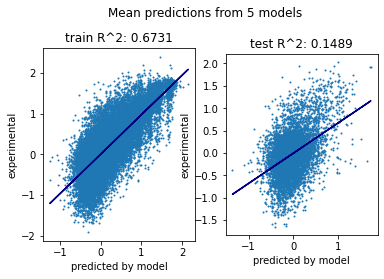

In [61]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

In [62]:
# in normal production setting cv is used just to search for model parameters,
# after that the model is trained on the whole train dataset.
# Let's compare our best model R^2 on test with the best ensemble.
# it won't be better than ensemble in the terms of performance, but it will run on new data faster.
model_all_data = CatBoostRegressor(
    iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
    metric_period=NITERATIONS//10
)
model_all_data.fit(x_full_train, y_full_train, eval_set=(x_full_train, y_full_train))
path = f"{SAVE_PREFIX}all.cbm"
model_all_data.save_model(path)
predictions = model_all_data.predict(x_full_test)
score=r2_score(y_full_test, predictions)
print("R^2 score on test set:", score)

0:	learn: 0.4803568	test: 0.4803568	best: 0.4803568 (0)	total: 93.6ms	remaining: 1m 33s
100:	learn: 0.3006439	test: 0.3006439	best: 0.3006439 (100)	total: 2.63s	remaining: 23.4s
200:	learn: 0.2405152	test: 0.2405152	best: 0.2405152 (200)	total: 4.53s	remaining: 18s
300:	learn: 0.2009111	test: 0.2009111	best: 0.2009111 (300)	total: 6.82s	remaining: 15.8s
400:	learn: 0.1748841	test: 0.1748841	best: 0.1748841 (400)	total: 9.12s	remaining: 13.6s


KeyboardInterrupt: 

## StratifiedKFold


In [ ]:
SAVE_PREFIX = os.path.join(savedir, "catboost_skf_")
NFOLDS=5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1500

split_data = dict()
for fold, (train_index, test_index) in enumerate(skf.split(x_full_train, topologies_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=5, learning_rate=1, loss_function='RMSE',
                              metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    # break


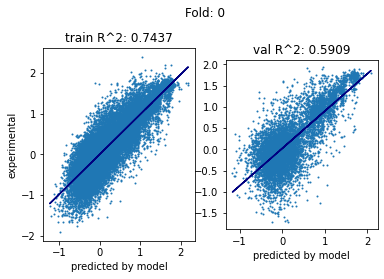

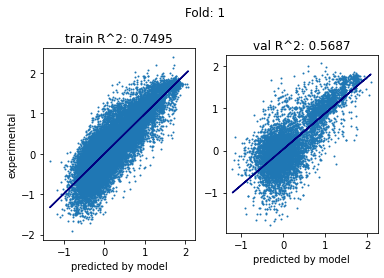

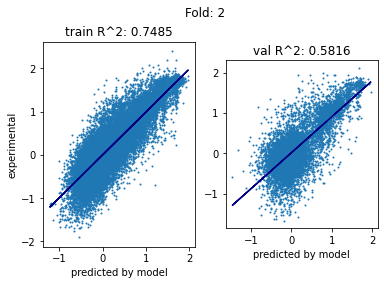

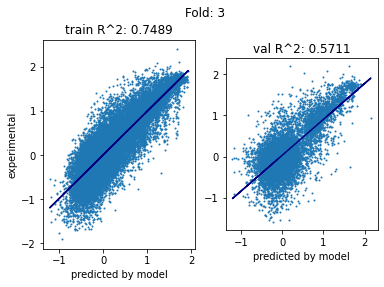

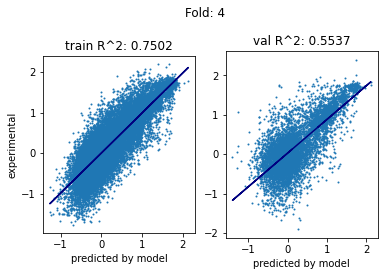

Train (using mean prediction) R^2= 0.7738061095400139
Test (using mean prediction) R^2= 0.25815981822634215


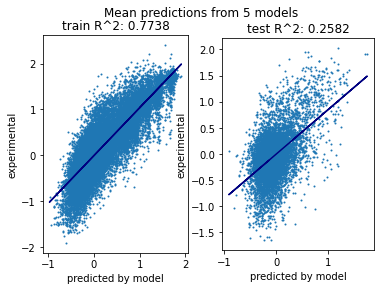

In [32]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
# print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
# print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");